In [8]:
import torch 
import torch.nn.functional as F 
import matplotlib.pyplot as plt 
import random
%matplotlib inline 

In [3]:
words = open('names.txt', 'r').read().splitlines() 
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [12]:
# build vocabulary of characters 
chars = sorted(list(set(''.join(word for word in words))))
stoi = {ch: i+1 for i, ch in enumerate(chars)}
stoi['.'] = 0 
itos = {i: ch for ch, i in stoi.items()}
print(itos)
vocab_size = len(stoi)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [10]:
# create the dataset 
def build_dataset(words, block_size):
    # block_size = 3 # how many characters to take to predict the next character 
    X, Y = [], [] 
    for word in words:
        # print(word)
        context = [0] * block_size 
        for ch in word + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix) 
            # print(''.join(itos[i] for i in context), '------>', itos[ix])    
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y 

random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8) 
n2 = int(len(words) * 0.9)

block_size = 3 

Xtr, Ytr = build_dataset(words[:n1], block_size)     # 80%
Xdev, Ydev = build_dataset(words[n1:n2], block_size) # 10%
Xte, Yte = build_dataset(words[n2:], block_size)     # 10%

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [166]:
# parameters setting 
g = torch.Generator().manual_seed(2147483647)
n_embd = 10
n_hidden = 200 
C = torch.randn((vocab_size, n_embd),              generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),  generator=g) * (5/3) * (n_embd * block_size)**-0.5 #* 0.2 
# b1 = torch.randn(n_hidden,                         generator=g) * 0.01 # we don't need it because BN subtracts the mean(bias) anyways.
W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0.01 
b2 = torch.randn(vocab_size,                       generator=g) * 0
bngain = torch.ones((1, n_hidden)) # gamma for BN 
bnbias = torch.zeros((1, n_hidden)) # beta for BN 
bnmean_running = torch.zeros((1, n_hidden)) # running average 
bnstd_running = torch.ones((1, n_hidden))
parameters = [C, W1, W2, b2, bngain, bnbias]
print(f"number of parameters = {sum(p.nelement() for p in parameters)}")
for p in parameters:
    p.requires_grad = True 

number of parameters = 12097


In [167]:
max_steps = 200000
batch_size = 32 
lossi = [] 

for i in range(max_steps):
    
    # mini-batch 
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass 
    emb = C[Xb] 
    embcat = emb.view(-1, n_embd * block_size)
    hpreact = embcat @ W1 #+ b1

    # batch normalization 
    bnmeani = hpreact.mean(0, keepdims=True)
    bnstdi = hpreact.std(0, keepdims=True)
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdims=True)) / hpreact.std(0, keepdims=True) + bnbias 

    with torch.no_grad(): # no gradient tracking needed 
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani 
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Yb) # logtits as input. 

    # backward pass 
    for p in parameters:
        p.grad = None 
    loss.backward() 

    lr = 0.1 if i < 100000 else 0.01 
    for p in parameters:
        p.data -= lr * p.grad 
        
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():4f}")
    lossi.append(loss.log10().item())


      0/ 200000: 3.303339
  10000/ 200000: 2.033922
  20000/ 200000: 1.917250
  30000/ 200000: 2.365371
  40000/ 200000: 2.107840
  50000/ 200000: 2.080066
  60000/ 200000: 2.092904
  70000/ 200000: 2.370324
  80000/ 200000: 2.439475
  90000/ 200000: 2.578929
 100000/ 200000: 2.388761
 110000/ 200000: 2.494926
 120000/ 200000: 2.011353
 130000/ 200000: 1.766294
 140000/ 200000: 2.386097
 150000/ 200000: 2.352748
 160000/ 200000: 1.898366
 170000/ 200000: 2.173161
 180000/ 200000: 2.332824
 190000/ 200000: 2.267527


In [44]:
# loss for uniform random distribtution 
# Our loss (at initialization) should be at least similar. 
print(f'uniform random prediction case: loss= {-torch.tensor(1/vocab_size).log().item()}')

# However, without good initalization, loss would be much larger then this value, and
# we would be wasting our time to do just easy work. 
# In our case, it seems the output of the last layer at intialization is overconfident for wrong predictions. 
# It can make loss very large. 
logits = torch.tensor([0.25, -0.25, 0.25, 0.25]) * 50
probs = F.softmax(logits, 0)
print(f'just simple 4 prediction case with overconfidence for wrong predictions: loss={-probs[1].log().item()}')

uniform random prediction case: loss= 3.295836925506592
just simple 4 prediction case with overconfidence for wrong predictions: loss=26.09861183166504


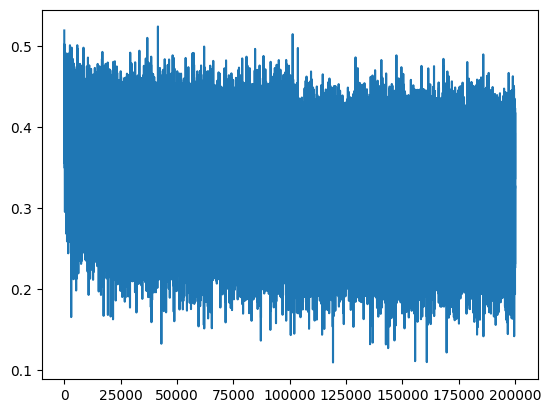

In [168]:
plt.plot(lossi)

In [157]:
# calibrate the batch norm at the end of training 
emb = C[Xtr] 
embcat = emb.view(-1, n_embd * block_size)
hpreact = embcat @ W1 + b1
bnmean = hpreact.mean(0, keepdims=True) 
bnstd = hpreact.std(0, keepdims=True)

In [161]:
@torch.no_grad() 
def split_loss(split, bn=True):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] 
    embcat = emb.view(-1, n_embd * block_size)
    hpreact = embcat @ W1 + b1
    if bn:
        hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias 
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

In [169]:
split_loss('train')
split_loss('val')

train 2.0664103031158447
val 2.1099743843078613


In [172]:
## ---------result---------- ## 

## vanilla 
# train 2.130587100982666
# val 2.1708500385284424

## +scale down the last layer's weight --> fix softmax confidently wrong 
# train 2.070660352706909
# val 2.134049654006958

## +fix tanh too saturated at init
# train 2.035435676574707
# val 2.1000843048095703

## kaiming init for tanh layer - gain was very similar to the previous one and the network is simple, so not much difference. 
# train 2.037860870361328
# val 2.1081783771514893

## unit guassian BN - forced zero-mean unit gaussian activations make it worse. 
# train 2.0760958194732666
# val 2.1139254570007324

## apply BN with trainable mean/std 
# train 2.0670766830444336
# val 2.1127257347106934

## BN with running mean/std
# train 2.0657734870910645
# val 2.1098971366882324

## BN bias=False 
# train 2.0664103031158447
# val 2.1099743843078613



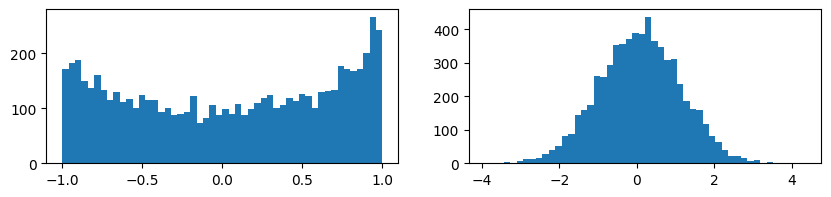

In [82]:
# diagnostic tools
# activations statistics 

# for tanh, if act value is near 1.0, the gradient value would be near 0.  (dtanh = 1-tanh**2) 
# which means, the neurons behind tanh won't get updated due to near-zero gradient. 
# --> dead neurons. 
plt.figure(figsize=(10, 2))
plt.subplot(1,2,1)
plt.hist(h.view(-1).tolist(), 50);
plt.subplot(1,2,2)
plt.hist(hpreact.view(-1).tolist(), 50);

1.296875% is saturated


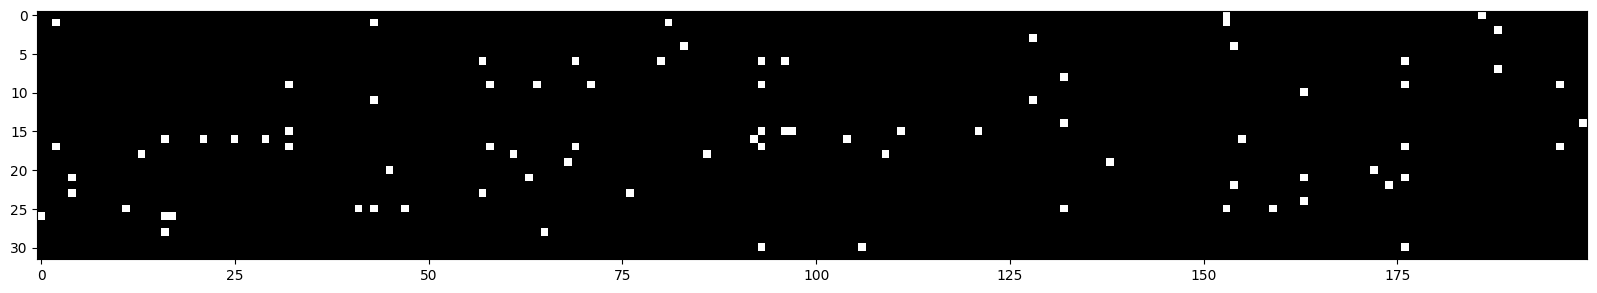

In [81]:
plt.figure(figsize=(20, 10))
print(f"{(h.abs() > 0.99).sum().item() / len(h.view(-1)) * 100}% is saturated")
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest') 

In [101]:
# variance(std**2) propagation through linear layers 
x = torch.randn(1000, 10) 
w = torch.randn(10, 20) * (10 ** -0.5)
y = x @ w 
h = torch.tanh(y)
print(f"x: mean/std = {x.mean().item(), x.std().item()}")
print(f"y: mean/std = {y.mean().item(), y.std().item()}")
print(f"h: mean/std = {h.mean().item(), h.std().item()}")

x: mean/std = (-0.0131724514067173, 1.005568027496338)
y: mean/std = (-0.004341845866292715, 1.014083981513977)
h: mean/std = (-0.005608119070529938, 0.613585889339447)


In [27]:
# sampling 

g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    out = [] 
    context = [0] * block_size 
    while True:
        emb = C[context] 
        embcat = emb.view(-1, n_embd * block_size)
        hpreact = embcat @ W1 + b1
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2 
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        context = context[1:] + [ix] 
        out.append(ix)
        if ix==0:
            break
    print(''.join(itos[ix] for ix in out))

dex.
malomonie.
rochitah.
melliston.
inrlenak.
katha.
samiyah.
javer.
gotai.
molie.
caiu.
kented.
jena.
millsede.
enkamirry.
folsp.
huckennatallys.
dasdro.
leenley.
alaisa.


## Pytorch-fy and refactor the code

In [308]:
# identical to pytorch nn module api 

class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None 
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias 
        return self.out 
        
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps 
        self.momentum = momentum 
        self.training = True 
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

        # trainable parameters through backprop 
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdims=True)
            xvar = x.var(0, keepdims=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var 
        xhat = (x - xmean) / (torch.sqrt(xvar) + self.eps) # normalization 
        self.out = self.gamma * xhat + self.beta # scaling and shift 

        # update running mean/var 
        if self.training:
            with torch.no_grad():
                self.running_mean = self.momentum * xmean + (1-self.momentum) * self.running_mean
                self.running_var = self.momentum * xvar + (1-self.momentum) * self.running_var 
        return self.out 
        
    def parameters(self):
        return [self.gamma, self.beta] 

class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out 
        
    def parameters(self):
        return [] 

In [344]:
g = torch.Generator().manual_seed(2147483647)
n_embd = 10
n_hidden = 100 
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size), 
]

with torch.no_grad():
    layers[-1].gamma *= 0.1 # make last layer less confident 
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3 # gain for tanh 

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(f"number of paramters = {sum(p.nelement() for p in parameters)}")
for p in parameters:
    p.requires_grad = True 

number of paramters = 47024


In [345]:
max_steps = 200000
batch_size = 32 
lossi = [] 
ud = []

for i in range(max_steps):
    
    # mini-batch 
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass 
    emb = C[Xb] 
    x = emb.view(-1, n_embd * block_size)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  

    # backward pass 
    # for layer in layers:
    #     layer.out.retain_grad() # DEBUGGING gradient 
    for p in parameters:
        p.grad = None 
    loss.backward() 

    lr = 0.1 if i < 100000 else 0.01 
    for p in parameters:
        p.data -= lr * p.grad 
        
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std()/p.data.std()).log10().item() for p in parameters])

    # if i > 1000:
    #     break # DEBUG purpose 

      0/ 200000: 3.290135
  10000/ 200000: 2.357430
  20000/ 200000: 2.095210
  30000/ 200000: 2.203158
  40000/ 200000: 2.140204
  50000/ 200000: 2.312958
  60000/ 200000: 2.286632
  70000/ 200000: 2.276702
  80000/ 200000: 2.642922
  90000/ 200000: 1.993424
 100000/ 200000: 1.933451
 110000/ 200000: 2.067868
 120000/ 200000: 2.104717
 130000/ 200000: 2.375441
 140000/ 200000: 2.484935
 150000/ 200000: 1.881400
 160000/ 200000: 2.231961
 170000/ 200000: 2.156968
 180000/ 200000: 1.754486
 190000/ 200000: 2.543410


layer 2 (Tanh      ): mean -0.00, std 0.69, saturated 14.53%
layer 5 (Tanh      ): mean 0.01, std 0.71, saturated 16.62%
layer 8 (Tanh      ): mean -0.01, std 0.74, saturated 16.06%
layer 11 (Tanh      ): mean -0.02, std 0.76, saturated 17.53%
layer 14 (Tanh      ): mean -0.01, std 0.78, saturated 19.28%


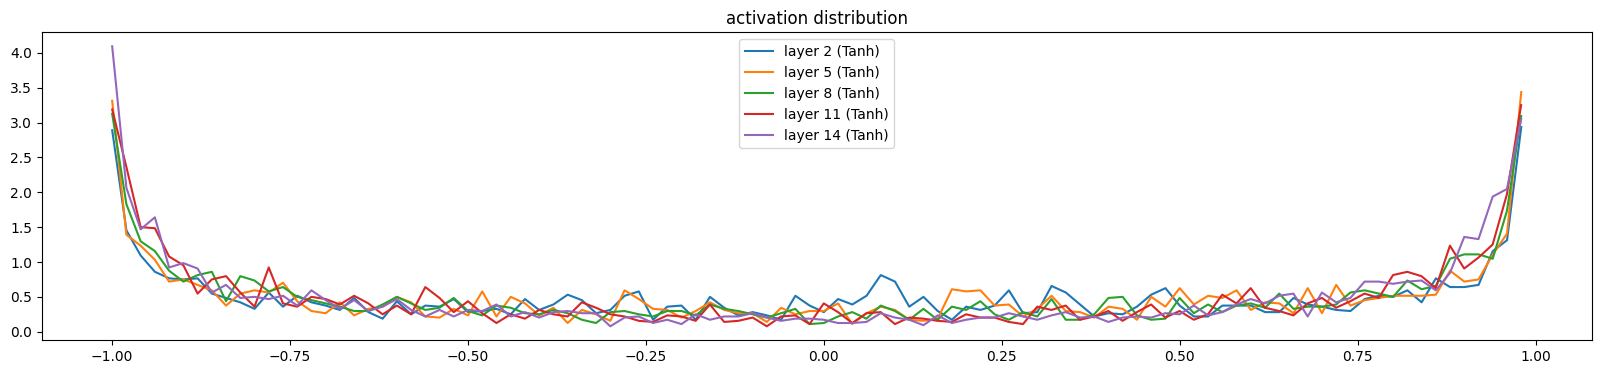

In [332]:
# visualization - histogram 
plt.figure(figsize=(20, 4))
legends = [] 
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out 
        print(f"layer {i} ({layer.__class__.__name__:10s}): mean {t.mean().item():.2f}, std {t.std().item():.2f}, saturated {(t.abs() > 0.97).float().mean() * 100:.2f}%")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title('activation distribution');

layer 2 (Tanh      ): mean 0.000000, std 3.875351e-03
layer 5 (Tanh      ): mean 0.000000, std 3.384642e-03
layer 8 (Tanh      ): mean 0.000000, std 3.263117e-03
layer 11 (Tanh      ): mean -0.000000, std 3.056062e-03
layer 14 (Tanh      ): mean -0.000000, std 3.407451e-03


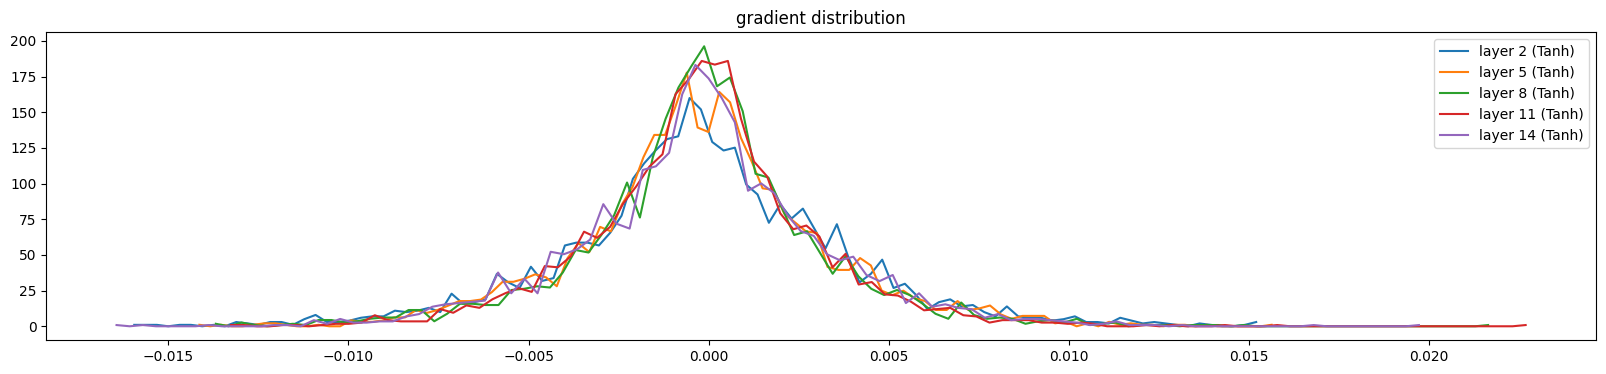

In [333]:
# visualization - histogram 
plt.figure(figsize=(20, 4))
legends = [] 
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad 
        print(f"layer {i} ({layer.__class__.__name__:10s}): mean {t.mean().item():f}, std {t.std().item():e}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title('gradient distribution');

weights (27, 10) | mean -0.000000 | std 1.253582e-02 | grad:data ratio 1.148954e-02
weights (30, 100) | mean -0.000227 | std 7.387423e-03 | grad:data ratio 1.798500e-02
weights (100, 100) | mean +0.000015 | std 5.192108e-03 | grad:data ratio 2.100532e-02
weights (100, 100) | mean +0.000006 | std 5.050091e-03 | grad:data ratio 2.083857e-02
weights (100, 100) | mean -0.000026 | std 4.512640e-03 | grad:data ratio 1.905976e-02
weights (100, 100) | mean -0.000015 | std 3.991246e-03 | grad:data ratio 1.737142e-02
weights (100, 27) | mean -0.000102 | std 6.789120e-03 | grad:data ratio 2.065342e-02


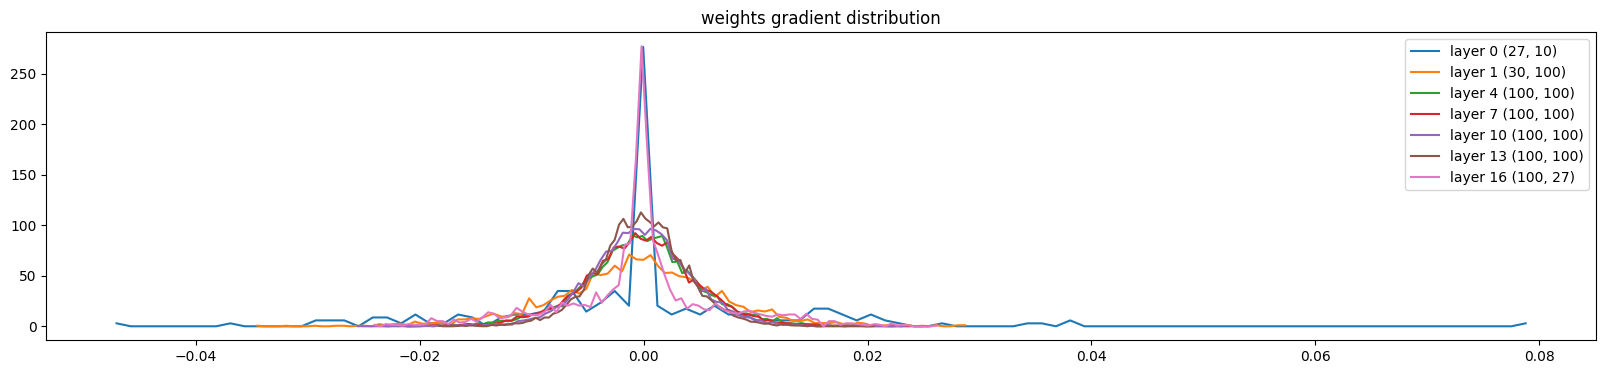

In [334]:
# visualization - histogram 
plt.figure(figsize=(20, 4))
legends = [] 
for i, p in enumerate(parameters):
    if p.ndim == 2:
        t = p.grad 
        print(f"weights {tuple(p.shape)} | mean {t.mean():+f} | std {t.std():e} | grad:data ratio {t.std()/p.std():e}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} {tuple(p.shape)}")
plt.legend(legends)
plt.title('weights gradient distribution');

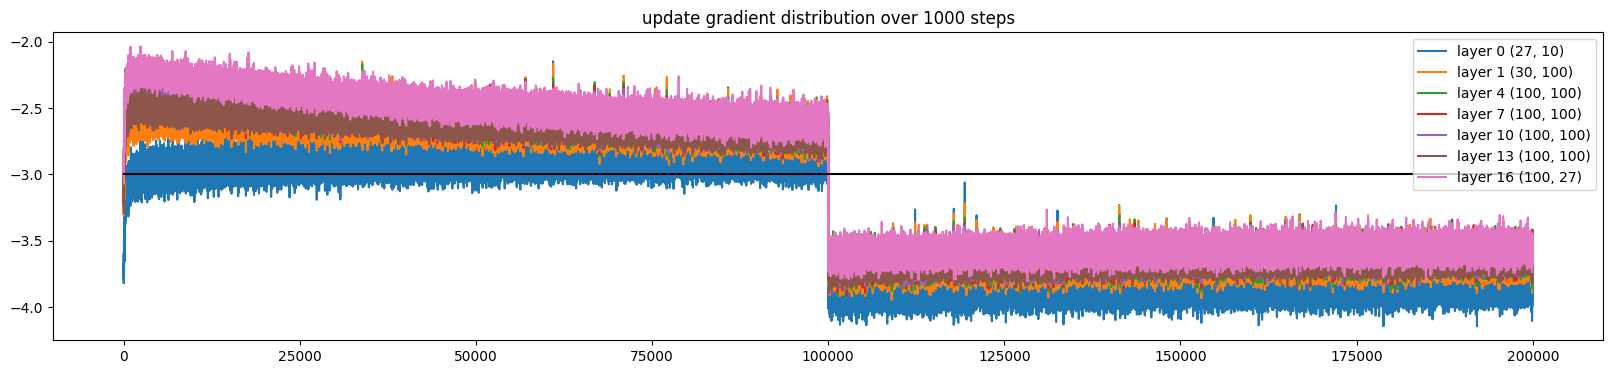

In [335]:
# visualization - histogram 
plt.figure(figsize=(20, 4))
legends = [] 
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f"layer {i} {tuple(p.shape)}")
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends)
plt.title('update gradient distribution over 1000 steps');

In [358]:
@torch.no_grad() 
def split_loss(split):
    for layer in layers:
        if isinstance(layer, BatchNorm1d):
            layer.training = False 
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] 
    x = emb.view(-1, n_embd * block_size)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

In [360]:
split_loss('train')
split_loss('val')

train 2.014098644256592
val 2.087989091873169


In [342]:
# sampling 
@torch.no_grad()
def sample_names():
    for layer in layers:
        if isinstance(layer, BatchNorm1d):
            layer.training = False 
    for _ in range(20):
        out = [] 
        context = [0] * block_size 
        while True:
            emb = C[context] 
            x = emb.view(-1, n_embd * block_size)
            for layer in layers:
                x = layer(x)
            probs = F.softmax(x, dim=1)
            ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
            context = context[1:] + [ix] 
            out.append(ix)
            if ix==0:
                break
        print(''.join(itos[ix] for ix in out))

In [367]:
sample_names()

anayara.
eliam.
zamimidric.
liannley.
janell.
drem.
eva.
coxle.
samyah.
mad.
willyn.
abdunioer.
jordanellah.
zen.
arias.
kruzella.
xandre.
mai.
calyanni.
saavis.


## Exercise 